# Training FSRS on simulated data

Requirement: fsrs-optimizer >= 5.4.1

In [1]:
import numpy as np
import pandas as pd

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0.4636,
    0.6048,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    _, _, _, _, _, revlogs = simulate(
        w=initial_parameters,
        learn_span=learn_span,
        first_rating_offset=np.array([0, 0, 0, 0]),
        first_session_len=np.array([0, 0, 0, 0]),
        forget_rating_offset=0,
        forget_session_len=0,
        fuzz=True,
    )

    flattened_revlogs = []

    for day in revlogs:
        card_ids = revlogs[day]["card_id"]
        ratings = revlogs[day]["rating"]
        for card_id, rating in zip(card_ids, ratings):
            flattened_revlogs.append(
                {"card_id": card_id, "review_rating": int(rating), "day": day}
            )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt


def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer()
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(verbose=False)
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, optimizer.w):
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset

def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 7


sample size: 272


  0%|          | 0/272 [00:00<?, ?it/s]

loss before: 0.2788, loss after: 0.2360
RMSE(bins): 0.0536
AUC: 0.7746
1.1596 -> 1.2095: SMAPE=4.2126%
1.7974 -> 6.3691: SMAPE=111.9623%
13.1205 -> 20.9057: SMAPE=45.7600%
49.3729 -> 58.286: SMAPE=16.5580%
7.2303 -> 7.1409: SMAPE=1.2442%
0.5081 -> 0.5401: SMAPE=6.1057%
1.5371 -> 1.4694: SMAPE=4.5036%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.6346: SMAPE=8.2426%
0.1261 -> 0.1158: SMAPE=8.5159%
0.9735 -> 1.0951: SMAPE=11.7567%
1.8924 -> 1.9011: SMAPE=0.4587%
0.1486 -> 0.1143: SMAPE=26.0936%
0.2407 -> 0.2154: SMAPE=11.0941%
2.1937 -> 2.2674: SMAPE=3.3041%
0.1518 -> 0.2854: SMAPE=61.1162%
3.0699 -> 3.0002: SMAPE=2.2965%
0.4636 -> 0.5166: SMAPE=10.8141%
0.6048 -> 0.6621: SMAPE=9.0457%
Avg. SMAPE: 18.0571%
loss before: 0.2788, loss after: 0.2462
RMSE(bins): 0.0606
AUC: 0.7171
--------------------------------
learn_span: 15


sample size: 870


  0%|          | 0/870 [00:00<?, ?it/s]

loss before: 0.3301, loss after: 0.3090
RMSE(bins): 0.0464
AUC: 0.6176
1.1596 -> 1.2572: SMAPE=8.0768%
1.7974 -> 1.6605: SMAPE=7.9181%
13.1205 -> 9.9877: SMAPE=27.1142%
49.3729 -> 49.4384: SMAPE=0.1326%
7.2303 -> 7.1902: SMAPE=0.5562%
0.5081 -> 0.5192: SMAPE=2.1610%
1.5371 -> 1.4389: SMAPE=6.5995%
0.001 -> 0.0097: SMAPE=162.6168%
1.5052 -> 1.5438: SMAPE=2.5320%
0.1261 -> 0.1278: SMAPE=1.3391%
0.9735 -> 1.0228: SMAPE=4.9391%
1.8924 -> 1.9253: SMAPE=1.7236%
0.1486 -> 0.0942: SMAPE=44.8105%
0.2407 -> 0.2156: SMAPE=11.0015%
2.1937 -> 2.2923: SMAPE=4.3959%
0.1518 -> 0.2349: SMAPE=42.9791%
3.0699 -> 3.0213: SMAPE=1.5957%
0.4636 -> 0.5166: SMAPE=10.8141%
0.6048 -> 0.6621: SMAPE=9.0457%
Avg. SMAPE: 18.4396%
loss before: 0.3301, loss after: 0.3105
RMSE(bins): 0.0476
AUC: 0.6000
--------------------------------
learn_span: 30


sample size: 2223


  0%|          | 0/2223 [00:00<?, ?it/s]

loss before: 0.3609, loss after: 0.3365
RMSE(bins): 0.0299
AUC: 0.5996
1.1596 -> 1.2211: SMAPE=5.1665%
1.7974 -> 2.587: SMAPE=36.0186%
13.1205 -> 9.1991: SMAPE=35.1386%
49.3729 -> 26.042: SMAPE=61.8734%
7.2303 -> 7.2395: SMAPE=0.1272%
0.5081 -> 0.5517: SMAPE=8.2280%
1.5371 -> 1.3941: SMAPE=9.7571%
0.001 -> 0.0354: SMAPE=189.0110%
1.5052 -> 1.4804: SMAPE=1.6613%
0.1261 -> 0.1468: SMAPE=15.1704%
0.9735 -> 0.9659: SMAPE=0.7837%
1.8924 -> 1.9045: SMAPE=0.6374%
0.1486 -> 0.1164: SMAPE=24.3019%
0.2407 -> 0.2189: SMAPE=9.4865%
2.1937 -> 2.2203: SMAPE=1.2053%
0.1518 -> 0.1441: SMAPE=5.2045%
3.0699 -> 2.8852: SMAPE=6.2031%
0.4636 -> 0.526: SMAPE=12.6112%
0.6048 -> 0.6812: SMAPE=11.8818%
Avg. SMAPE: 22.8667%
loss before: 0.3609, loss after: 0.3383
RMSE(bins): 0.0324
AUC: 0.5741
--------------------------------
learn_span: 60


sample size: 5325


  0%|          | 0/5325 [00:00<?, ?it/s]

loss before: 0.3586, loss after: 0.3332
RMSE(bins): 0.0236
AUC: 0.5657
1.1596 -> 1.0412: SMAPE=10.7597%
1.7974 -> 1.7921: SMAPE=0.2953%
13.1205 -> 12.6702: SMAPE=3.4920%
49.3729 -> 36.0569: SMAPE=31.1741%
7.2303 -> 7.2249: SMAPE=0.0747%
0.5081 -> 0.5506: SMAPE=8.0287%
1.5371 -> 1.4615: SMAPE=5.0424%
0.001 -> 0.0015: SMAPE=40.0000%
1.5052 -> 1.5154: SMAPE=0.6754%
0.1261 -> 0.2527: SMAPE=66.8427%
0.9735 -> 1.0121: SMAPE=3.8880%
1.8924 -> 1.9428: SMAPE=2.6283%
0.1486 -> 0.0946: SMAPE=44.4079%
0.2407 -> 0.2584: SMAPE=7.0928%
2.1937 -> 2.3205: SMAPE=5.6178%
0.1518 -> 0.0572: SMAPE=90.5263%
3.0699 -> 3.0603: SMAPE=0.3132%
0.4636 -> 0.5063: SMAPE=8.8050%
0.6048 -> 0.6351: SMAPE=4.8875%
Avg. SMAPE: 17.6080%
loss before: 0.3586, loss after: 0.3343
RMSE(bins): 0.0257
AUC: 0.5460
--------------------------------
learn_span: 120


sample size: 11773


  0%|          | 0/11773 [00:00<?, ?it/s]

loss before: 0.3572, loss after: 0.3367
RMSE(bins): 0.0190
AUC: 0.5671
1.1596 -> 1.1605: SMAPE=0.0776%
1.7974 -> 1.775: SMAPE=1.2541%
13.1205 -> 12.5756: SMAPE=4.2411%
49.3729 -> 44.6353: SMAPE=10.0791%
7.2303 -> 7.1844: SMAPE=0.6368%
0.5081 -> 0.3599: SMAPE=34.1475%
1.5371 -> 1.6283: SMAPE=5.7623%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.4739: SMAPE=2.1013%
0.1261 -> 0.1272: SMAPE=0.8685%
0.9735 -> 0.9934: SMAPE=2.0235%
1.8924 -> 1.9041: SMAPE=0.6164%
0.1486 -> 0.1267: SMAPE=15.9099%
0.2407 -> 0.2211: SMAPE=8.4885%
2.1937 -> 2.3459: SMAPE=6.7054%
0.1518 -> 0.1724: SMAPE=12.7082%
3.0699 -> 3.1483: SMAPE=2.5216%
0.4636 -> 0.5237: SMAPE=12.1746%
0.6048 -> 0.6634: SMAPE=9.2414%
Avg. SMAPE: 6.8188%
loss before: 0.3572, loss after: 0.3368
RMSE(bins): 0.0191
AUC: 0.5669
--------------------------------
learn_span: 240


sample size: 25566


  0%|          | 0/25566 [00:00<?, ?it/s]

loss before: 0.3439, loss after: 0.3270
RMSE(bins): 0.0169
AUC: 0.5674
1.1596 -> 1.0469: SMAPE=10.2153%
1.7974 -> 1.6331: SMAPE=9.5788%
13.1205 -> 14.2606: SMAPE=8.3276%
49.3729 -> 50.8964: SMAPE=3.0388%
7.2303 -> 7.1377: SMAPE=1.2890%
0.5081 -> 0.3887: SMAPE=26.6280%
1.5371 -> 1.6434: SMAPE=6.6845%
0.001 -> 0.0024: SMAPE=82.3529%
1.5052 -> 1.5396: SMAPE=2.2596%
0.1261 -> 0.1829: SMAPE=36.7638%
0.9735 -> 1.0632: SMAPE=8.8084%
1.8924 -> 1.8903: SMAPE=0.1110%
0.1486 -> 0.112: SMAPE=28.0890%
0.2407 -> 0.236: SMAPE=1.9719%
2.1937 -> 2.2942: SMAPE=4.4787%
0.1518 -> 0.1476: SMAPE=2.8056%
3.0699 -> 3.2023: SMAPE=4.2218%
0.4636 -> 0.4905: SMAPE=5.6388%
0.6048 -> 0.6222: SMAPE=2.8362%
Avg. SMAPE: 12.9526%
loss before: 0.3439, loss after: 0.3272
RMSE(bins): 0.0179
AUC: 0.5646
--------------------------------
learn_span: 480


sample size: 54312


  0%|          | 0/54312 [00:00<?, ?it/s]

loss before: 0.3458, loss after: 0.3317
RMSE(bins): 0.0132
AUC: 0.5613
1.1596 -> 1.2169: SMAPE=4.8222%
1.7974 -> 2.1562: SMAPE=18.1505%
13.1205 -> 13.3026: SMAPE=1.3783%
49.3729 -> 53.4383: SMAPE=7.9085%
7.2303 -> 7.1412: SMAPE=1.2400%
0.5081 -> 0.4465: SMAPE=12.9059%
1.5371 -> 1.6354: SMAPE=6.1970%
0.001 -> 0.003: SMAPE=100.0000%
1.5052 -> 1.4512: SMAPE=3.6531%
0.1261 -> 0.1461: SMAPE=14.6951%
0.9735 -> 1.0307: SMAPE=5.7080%
1.8924 -> 1.8712: SMAPE=1.1266%
0.1486 -> 0.1226: SMAPE=19.1740%
0.2407 -> 0.2421: SMAPE=0.5800%
2.1937 -> 2.3777: SMAPE=8.0501%
0.1518 -> 0.1627: SMAPE=6.9316%
3.0699 -> 3.0926: SMAPE=0.7367%
0.4636 -> 0.4472: SMAPE=3.6012%
0.6048 -> 0.5509: SMAPE=9.3277%
Avg. SMAPE: 11.9046%
loss before: 0.3458, loss after: 0.3318
RMSE(bins): 0.0139
AUC: 0.5604
--------------------------------
learn_span: 960


sample size: 103257


  0%|          | 0/103257 [00:00<?, ?it/s]

loss before: 0.3380, loss after: 0.3272
RMSE(bins): 0.0112
AUC: 0.5625
1.1596 -> 1.2743: SMAPE=9.4252%
1.7974 -> 1.926: SMAPE=6.9077%
13.1205 -> 13.2486: SMAPE=0.9716%
49.3729 -> 49.7431: SMAPE=0.7470%
7.2303 -> 7.0199: SMAPE=2.9529%
0.5081 -> 0.4991: SMAPE=1.7871%
1.5371 -> 1.614: SMAPE=4.8808%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.3631: SMAPE=9.9083%
0.1261 -> 0.1236: SMAPE=2.0024%
0.9735 -> 1.0905: SMAPE=11.3372%
1.8924 -> 1.8123: SMAPE=4.3242%
0.1486 -> 0.1673: SMAPE=11.8392%
0.2407 -> 0.2485: SMAPE=3.1889%
2.1937 -> 2.6068: SMAPE=17.2107%
0.1518 -> 0.1754: SMAPE=14.4254%
3.0699 -> 3.1328: SMAPE=2.0281%
0.4636 -> 0.5041: SMAPE=8.3704%
0.6048 -> 0.6164: SMAPE=1.8998%
Avg. SMAPE: 6.0109%
loss before: 0.3380, loss after: 0.3272
RMSE(bins): 0.0113
AUC: 0.5626
--------------------------------


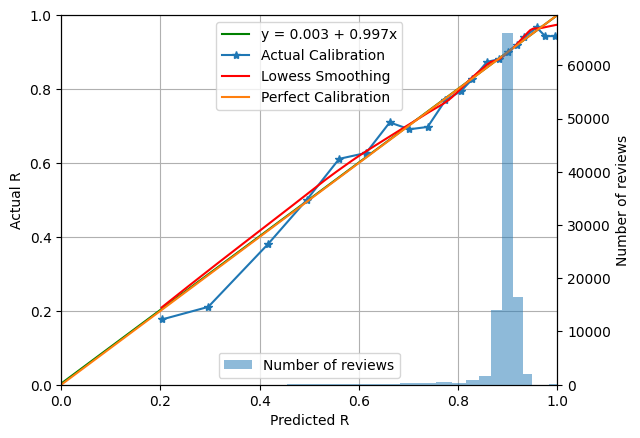

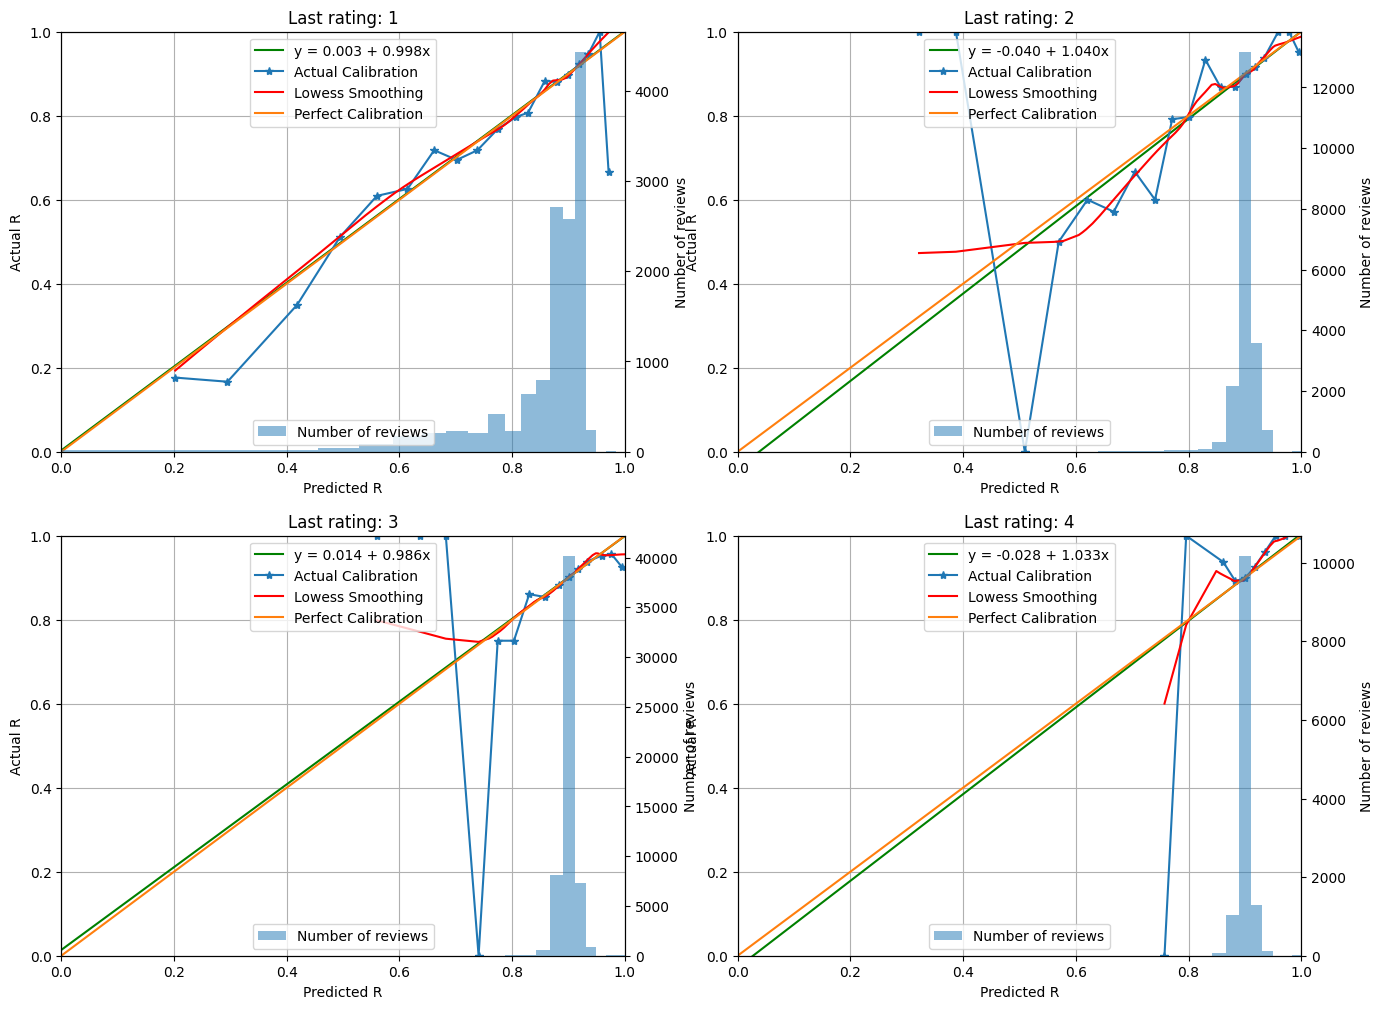

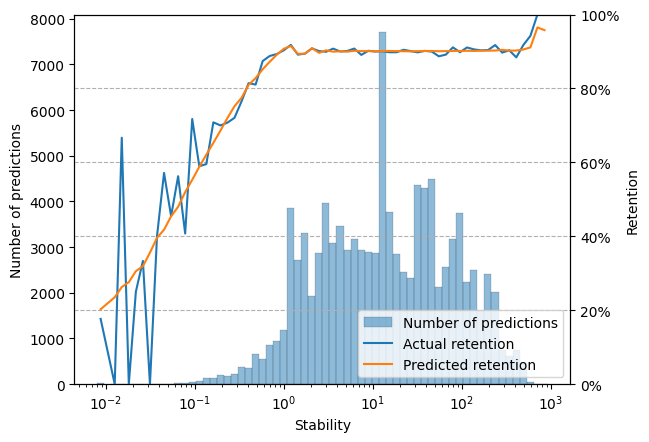

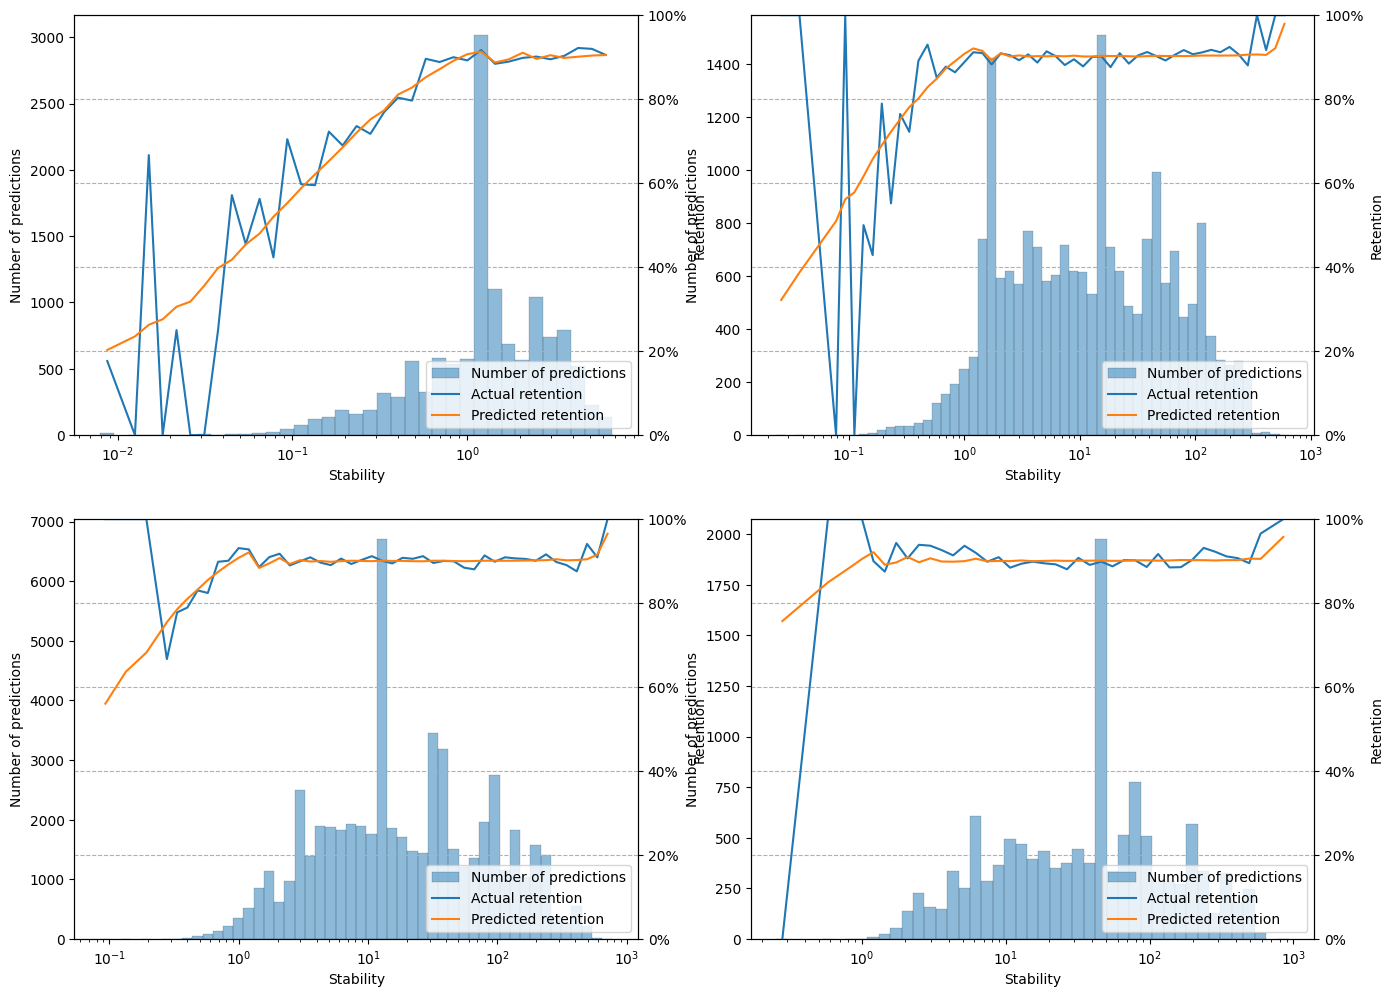

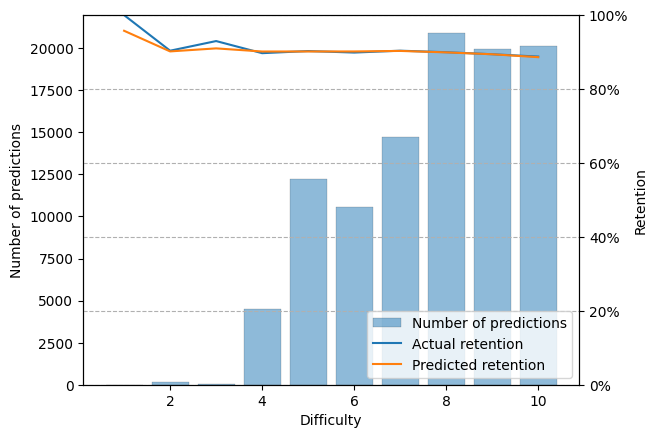

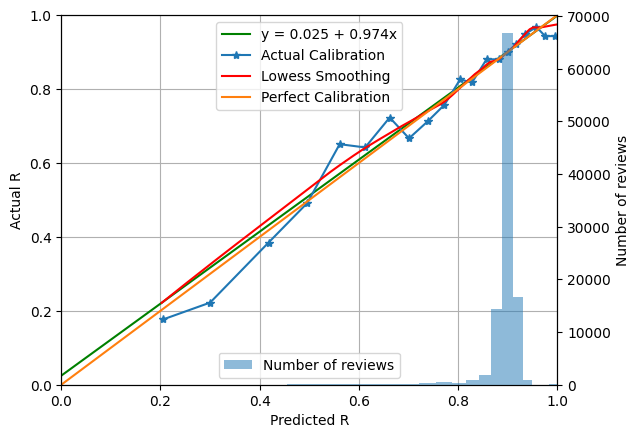

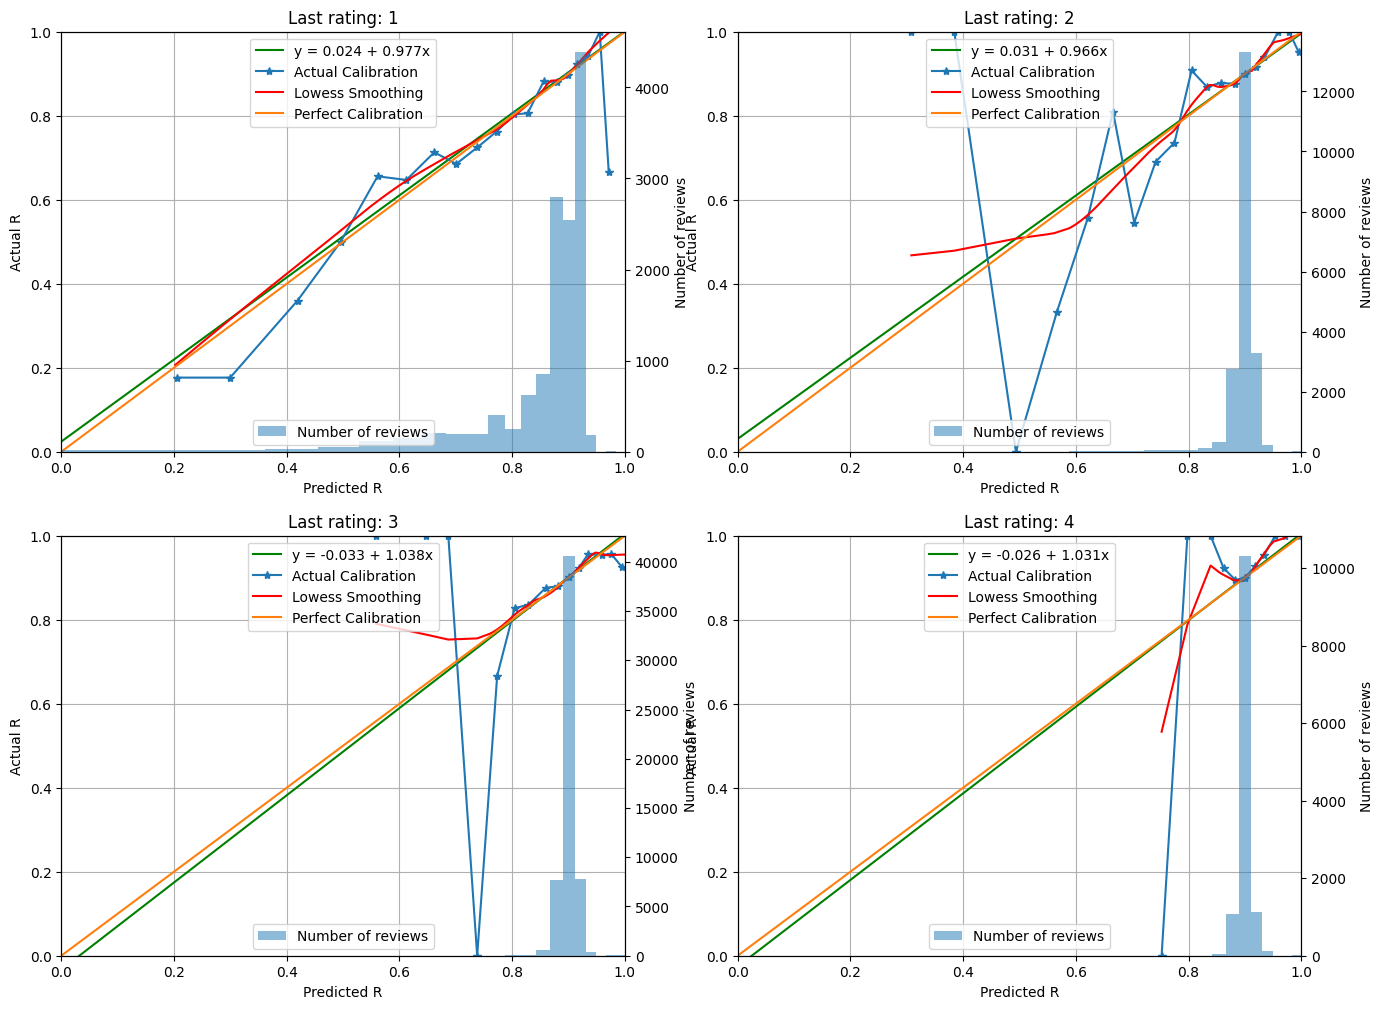

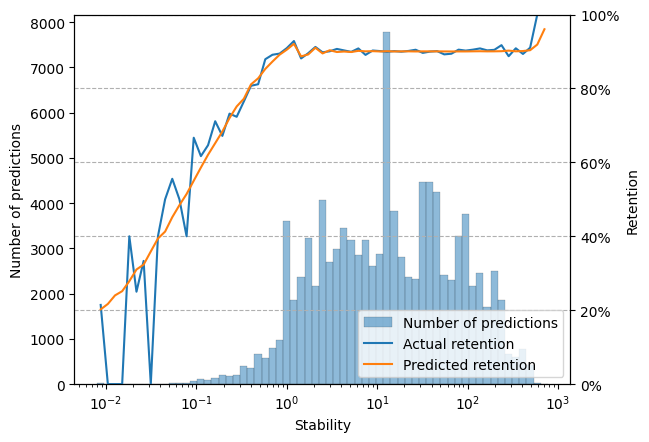

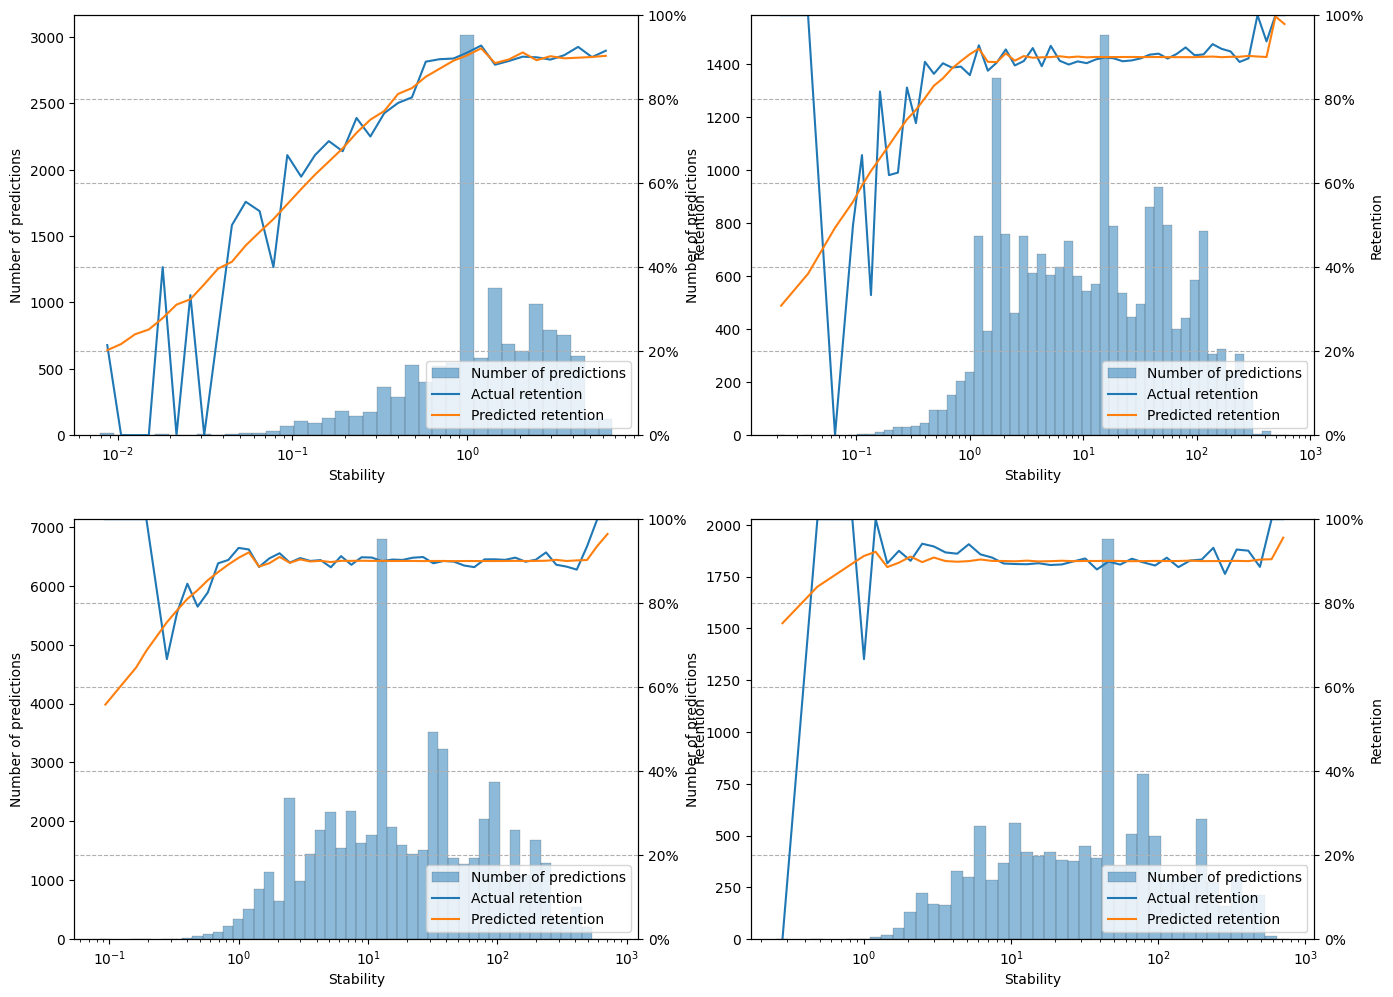

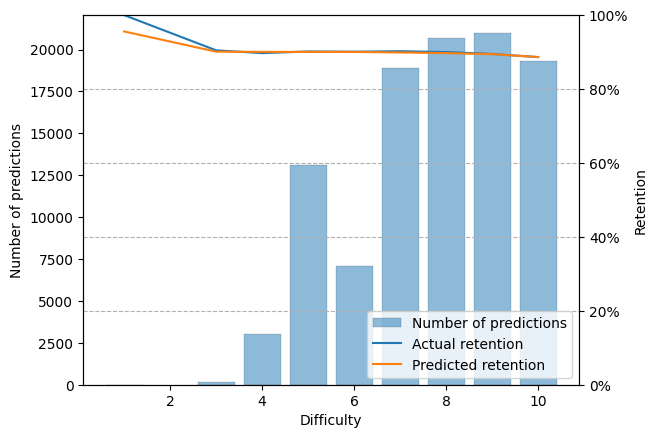

In [4]:
learn_span_list = [7, 15, 30, 60, 120, 240, 480, 960]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

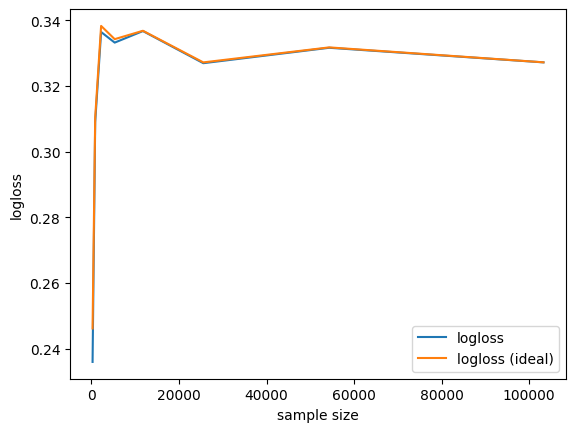

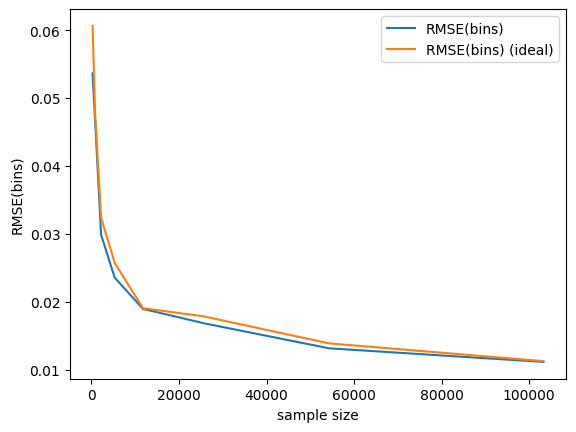

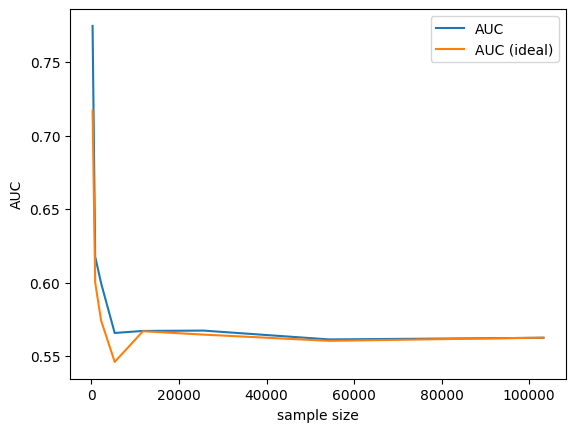

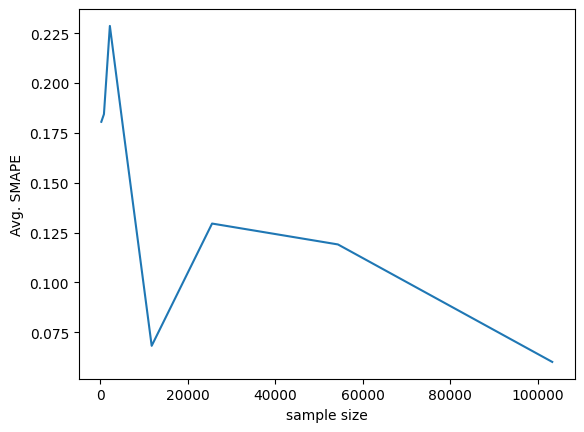

In [5]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()
